# Ground Plane Fitting and Scan Line Run for 3D LiDAR

Ground Plane Fitting (GPF) and Naive Baseline for 3D LiDAR Segmentation

This notebook implements ground segmentation using the Ground Plane Fitting (GPF) algorithm 
proposed in:

"Fast Segmentation of 3D Point Clouds: A Paradigm on LiDAR Data for Autonomous Vehicle Applications"
by D. Zermas, I. Izzat, and N. Papanikolopoulos, 2017.

The implementation also includes a naive baseline method for comparison, as well as 
basic clustering and visualization tools.

# Imports

In [1]:
# Standard library imports
import os
from pathlib import Path

# Third-party imports
import numpy as np
import yaml
import matplotlib.pyplot as plt
from sklearn.neighbors import KDTree  # Used for spatial clustering
import open3d as o3d

import json
import threading
import subprocess

from tqdm import tqdm  # Importa tqdm para barra de progresso

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


# Hyperparameters

In [2]:
# --- Hyperparameters for Ground Plane Fitting (GPF) ---
NUM_LOWEST_POINTS = 10000          # Number of lowest elevation points used to estimate initial ground seed (LPR)
NUM_ITERATIONS = 5                 # Number of iterations for plane refinement in GPF
SEED_HEIGHT_THRESHOLD = 0.4        # Max height above LPR to consider a point as a ground seed
PLANE_DISTANCE_THRESHOLD = 0.2     # Max distance from plane to classify a point as ground

# --- Parameters for Scan Line Run (SLR) clustering ---
SLR_RUN_DISTANCE_THRESHOLD = 0.2   # Max distance between consecutive points in a scanline to form a run
SLR_MERGE_THRESHOLD = 1.0          # Max distance between runs in adjacent scanlines to be considered the same cluster


# Naive Baseline Method

In [3]:
def naive_ground_extractor(point_cloud: np.ndarray, num_lowest_points: int) -> np.ndarray:
    """
    Naive ground extraction method (baseline).
    
    This simple method selects the points with the lowest Z values 
    and assumes they belong to the ground surface. It does not model 
    the ground plane and is used as a baseline for comparison against 
    more robust algorithms like Ground Plane Fitting (GPF).
    
    Args:
        point_cloud (np.ndarray): N x D array of point cloud data.
        num_lowest_points (int): Number of points with lowest Z values to classify as ground.
    
    Returns:
        ground_indices (np.ndarray): Indices of the selected ground points.
    """

    # Select indices of points with the lowest Z values
    return np.argsort(point_cloud[:, 2])[:num_lowest_points]

# Ground Plane Fitting (GPF)

In [4]:
def extract_initial_seed_indices(
    point_cloud: np.ndarray, 
    num_points: int = 1000, 
    height_threshold: float = 0.4
) -> np.ndarray:
    """
    Extract initial seed points for ground plane estimation (GPF).
    
    Args:
        point_cloud (np.ndarray): N x 3 array of points (x, y, z).
        num_points (int): number of lowest Z points to average as LPR.
        height_threshold (float): threshold to select seeds close to LPR height.
    
    Returns:
        seeds_ids (np.ndarray): indices of points selected as initial seeds.
    """

    # Step 1: Sort the point cloud by Z axis (height)
    sorted_indices = np.argsort(point_cloud[:, 2])  # Get indices sorted by height
    sorted_points = point_cloud[sorted_indices]     # Apply sorting

    # Step 2: Compute LPR (Lowest Point Representative)
    lpr_height = np.mean(sorted_points[:num_points, 2])

    # Step 3: Select point ids that are within threshold distance from LPR
    mask = sorted_points[:, 2] < (lpr_height + height_threshold)
    return sorted_indices[mask]

In [5]:
def estimate_ground_plane(points: np.ndarray) -> "tuple[np.ndarray, float]":
    """
    Estimate the ground plane parameters using Singular Value Decomposition (SVD).
    
    Args:
        points (np.ndarray): N x 3 array (x, y, z) of seed points assumed to be on or near the ground.

    Returns:
        tuple: 
            - normal (np.ndarray): Normal vector (a, b, c) of the estimated ground plane.
            - d (float): Offset term of the estimated plane equation (ax + by + cz + d = 0).
    """
    
    # Step 1: Compute centroid of the seed points
    centroid  = np.mean(points, axis=0)
    centered_points  = points - centroid 

    # Step 2: Compute the covariance matrix of centered points
    covariance_matrix = np.cov(centered_points.T)

    # Step 3: Perform SVD on the covariance matrix to extract principal directions
    _, _, vh = np.linalg.svd(covariance_matrix)

    # Step 4: Normal vector is the direction with smallest variance (last column of V^T)
    normal = vh[-1]

    # Step 5: Compute plane bias using point-normal form: ax + by + cz + d = 0
    d = -np.dot(normal, centroid)

    return (normal, d)

In [6]:
def refine_ground_plane(
    point_cloud: np.ndarray,
    num_points: int = 1000,
    height_threshold: float = 0.4,
    distance_threshold: float = 0.2,
    num_iterations: int = 5
) -> "tuple[np.ndarray, tuple[np.ndarray, float]]":
    """
    Iteratively refine the ground plane estimation using seed points and distance threshold.
    
    Args:
        point_cloud (np.ndarray): Nx6 array [x, y, z, true_label, pred_label, scanline_id].
        num_points (int): Number of lowest Z points used to compute the initial ground seed height (LPR).
        height_threshold (float): Vertical distance threshold from the LPR used to select initial seed points.
        distance_threshold (float): Max allowed point-to-plane distance for a point to be considered ground.
        num_iterations (int): Number of iterations to refine the plane and ground classification.
    
    Returns:
        tuple: 
            - point_cloud (np.ndarray): Nx6 array [x, y, z, true_label, pred_label, scanline_id], input array with ground points labeled.
            - normal (np.ndarray): Normal vector (a, b, c) of the estimated ground plane.
            - d (float): Offset term of the estimated plane equation (ax + by + cz + d = 0).
    """

    # Step 0: Use only XYZ for plane estimation
    xyz = point_cloud[:, :3]

    # Step 1: Get initial seed points based on lowest Z values
    seed_indices = extract_initial_seed_indices(xyz, num_points, height_threshold)

    for _ in range(num_iterations):
        # Step 2: Estimate ground plane using current seeds
        normal, d = estimate_ground_plane(xyz[seed_indices])

        # Step 3: Compute distances from all points to the estimated plane
        distances = np.abs(np.dot(xyz, normal) + d) / np.linalg.norm(normal)

        # Step 4: Classify as ground if within distance threshold
        is_ground = distances < distance_threshold

        # Step 5: Update seeds with newly classified ground points
        seed_indices = np.where(is_ground)[0]

    # Final ground classification using last iteration's result
    point_cloud[seed_indices, 4] = 9 # Set label = 9 for ground

    return (point_cloud, (normal, d))

# Scan Line Run (SLR)

In [7]:
def group_by_scanline(point_cloud: np.ndarray) -> "list[np.ndarray]":
    """
    Group points by their scanline index in a vectorized way.

    Args:
        point_cloud (np.ndarray): N x 6 array [x, y, z, true_label, pred_label, scanline_id].

    Returns:
        list[np.ndarray]: List of arrays. Each array contains the points (N_i x 6)
                          from one scanline, sorted by scanline_id.
    """
    scan_ids = point_cloud[:, 5].astype(int)
    unique_ids = np.unique(scan_ids)

    return [point_cloud[scan_ids == s_id] for s_id in unique_ids]

In [8]:
def find_runs(scanline_points: np.ndarray, distance_threshold: float = 0.5) -> "list[np.ndarray]":
    """
    Identify runs within a single scanline based on distance between consecutive points.

    Args:
        scanline_points (np.ndarray): N x 6 array [x, y, z, true_label, pred_label, scanline_id].
        distance_threshold (float): Distance threshold to consider two points part of the same run.

    Returns:
        list[np.ndarray]: List of arrays where each array contains the points of a run.
    """
    num_points = len(scanline_points)
    runs = []
    current_run_indices = [0]  # start with the index of the first point

    for i in range(1, num_points):
        dist = np.linalg.norm(scanline_points[i, :3] - scanline_points[i - 1, :3])
        if dist < distance_threshold:
            current_run_indices.append(i)
        else:
            runs.append(scanline_points[current_run_indices])
            current_run_indices = [i]

    # append the last run
    runs.append(scanline_points[current_run_indices])

    # Check if first and last points are close (circular case)
    circular_dist = np.linalg.norm(scanline_points[0, :3] - scanline_points[-1, :3])
    # Only merge runs if:
    # - the scanline appears to be circular (first and last points are close), and
    # - there is more than one run (otherwise merging doesn't make sense)
    if circular_dist < distance_threshold and len(runs) > 1:
        # Merge last run with the first
        runs[0] = np.vstack((runs[-1], runs[0]))
        runs.pop()

    return runs

In [9]:
def update_labels(
    runs_current: "list[np.ndarray]",
    runs_above: "list[np.ndarray]",
    label_equivalences: dict,
    merge_threshold: float = 1.0
):
    """
    Update labels of current scanline runs based on proximity to runs from previous scanline using KDTree.

    Args:
        runs_current (list[np.ndarray]): List of N x 6 arrays for current scanline runs.
        runs_above (list[np.ndarray]): List of N x 6 arrays for previous scanline runs.
        label_equivalences (dict): Dictionary of label equivalences.
        merge_threshold (float): Maximum distance to consider connection between runs.
    """
    def resolve_label(label: int) -> int:
        """Find the final label by following the equivalence chain."""
        while label != label_equivalences[label]:
            label = label_equivalences[label]
        return label

    global_label_counter = max(label_equivalences.values()) + 1

    points_above = np.vstack(runs_above)
    tree_above = KDTree(points_above[:, :3])  # use only x, y, z

    for run in runs_current:
        neighbor_labels = set()

        # Check nearest neighbor of each point in current run
        dists, indices = tree_above.query(run[:, :3], k=1)
        for dist, idx in zip(dists[:, 0], indices[:, 0]):
            if dist < merge_threshold:
                neighbor_label = points_above[idx, 4]
                resolved_label = resolve_label(neighbor_label)
                neighbor_labels.add(resolved_label)

        if not neighbor_labels:
            # No close neighbors → assign new label
            while global_label_counter == 9 or global_label_counter in label_equivalences:
                global_label_counter += 1
            run[:, 4] = global_label_counter
            label_equivalences[global_label_counter] = global_label_counter
        else:
            # Inherit the smallest label and unify equivalences
            min_label = min(neighbor_labels)
            run[:, 4] = min_label
            for lbl in neighbor_labels:
                label_equivalences[lbl] = min_label

In [10]:
def extract_clusters(scanlines: "list[np.ndarray]", label_equivalences: dict) -> np.ndarray:
    """
    Apply resolved labels to all points and return a unified point cloud.

    Args:
        scanlines (list[np.ndarray]): List of N x 6 arrays for each scanline.
        label_equivalences (dict): Dictionary of final label equivalences.

    Returns:
        np.ndarray: N x 6 array with updated labels in column 4.
    """
    non_ground_points = np.vstack(scanlines)

    for idx in range(0, len(non_ground_points)):
        non_ground_points[idx][4] = label_equivalences[non_ground_points[idx][4]]

    return non_ground_points

In [11]:
def scan_line_run_clustering(
    point_cloud: np.ndarray, 
    distance_threshold: float = 0.5, 
    merge_threshold: float = 1.0
) -> np.ndarray:
    """
    Perform scan line run clustering on non-ground points (predicted_label == 0).

    This function detects connected components (runs) within scanlines, propagates
    and merges labels across scanlines, and assigns final labels to each point.

    Args:
        point_cloud (np.ndarray): N x 6 array [x, y, z, true_label, predicted_label, scanline_index].
        distance_threshold (float): Distance threshold to consider two points part of the same run.
        merge_threshold (float): Maximum distance to consider connection between runs.

    Returns:
        np.ndarray: Point cloud with updated predicted labels (column 4).
    """
    label_counter = 0
    label_equivalences = {}

    # Filter non-ground points (predicted_label == 0)
    non_ground_mask = point_cloud[:, 4] == 0
    non_ground_points = point_cloud[non_ground_mask]
    ground_points = point_cloud[~non_ground_mask]

    # Group points into scanlines
    scanlines = group_by_scanline(non_ground_points)

    # Initialize clustering with the first scanline
    runs_above = find_runs(scanlines[0], distance_threshold)
    for runs in runs_above:
        label_counter += 1
        if label_counter == 9:  # reserve label 9 for ground
            label_counter += 1
        runs[:, 4] = label_counter
        label_equivalences[label_counter] = label_counter

    scanlines[0] = np.vstack(runs_above)
        
    # Propagate labels through remaining scanlines
    for i in range(1, len(scanlines)):
        runs_current = find_runs(scanlines[i], distance_threshold)
        update_labels(runs_current, runs_above, label_equivalences, merge_threshold)

        scanlines[i] = np.vstack(runs_current)
        runs_above = runs_current

    clustered_points = extract_clusters(scanlines, label_equivalences)
    return np.vstack((clustered_points, ground_points))

# Dataset

In [12]:
class Dataset:
    def __init__(self, data_path: str, split: str = 'train') -> None:
        """
        Initialize dataset loader.

        Args:
            data_path (str or Path): Base path to the SemanticKITTI dataset.
            split (str): Dataset split to use ('train', 'valid', or 'test').
        """
        self.data_path: Path = Path(data_path)
        self.split: str = split
        self.is_test: bool = split == 'test'

        # Paths to YAML config and data folders
        # self.yaml_path: Path = self.data_path / 'semantic-kitti.yaml'
        self.yaml_path: Path = Path('semantic-kitti.yaml')
        self.velodynes_path: Path = self.data_path / 'data_odometry_velodyne/dataset/sequences'
        self.labels_path: Path = self.data_path / 'data_odometry_labels/dataset/sequences'

        # Load dataset metadata and label mappings
        with open(self.yaml_path, 'r') as file:
            metadata: dict = yaml.safe_load(file)

        self.sequences: list[int] = metadata['split'][split]
        self.learning_map: dict[int, int] = metadata['learning_map']

        # Convert label map to numpy for fast lookup
        max_label: int = max(self.learning_map.keys())
        self.learning_map_np: np.ndarray = np.zeros((max_label + 1,), dtype=np.uint32)
        for raw_label, mapped_label in self.learning_map.items():
            self.learning_map_np[raw_label] = mapped_label

        # Collect all frame paths for selected sequences
        self.frame_paths: list[tuple[str, str]] = self._collect_frame_paths()

    def _collect_frame_paths(self) -> "list[tuple[str, str]]":
        """Collect all (sequence, frame_id) pairs from the dataset split."""
        frame_list = []
        for seq in self.sequences:
            seq_str = f"{int(seq):02d}"
            seq_velo_path = self.velodynes_path/seq_str/'velodyne'
            velo_files = sorted(seq_velo_path.glob('*.bin'))
            for file in velo_files:
                frame_list.append((seq_str, file.stem))
        return frame_list

    def __len__(self) -> int:
        """Return number of samples in the dataset split."""
        return len(self.frame_paths)

    def _compute_scanline_ids(self, point_cloud: np.ndarray, n_scans: int = 64) -> np.ndarray:
        """
        Approximate scanline indices based on point order.

        Args:
            point_cloud (np.ndarray): Nx3 array of 3D points.
            n_scans (int): Number of LiDAR scanlines (e.g., 64 for HDL-64E).

        Returns:
            np.ndarray: Nx1 array with estimated scanline indices (0 to n_scans - 1).
        """
        total_points = point_cloud.shape[0]
        scanline_ids = np.floor(np.linspace(0, n_scans, total_points, endpoint=False)).astype(int)
        return scanline_ids.reshape(-1, 1)

    def __getitem__(self, idx: int) -> "tuple[np.ndarray, dict[str, np.ndarray]]":
        """
        Load a sample from the dataset.

        Args:
            idx (int): Index of the frame to load.

        Returns:
            tuple:
                - point_cloud_with_label (np.ndarray): Nx6 array [x, y, z, true_label, pred_label, scanline_id].
                - item_dict (dict): Contains 'point_cloud', 'label', and 'mask'.
        """

        seq, frame_id = self.frame_paths[idx]

        # Load point cloud (Nx4), drop reflectance
        velodyne_file_path = self.velodynes_path/seq/'velodyne'/f"{frame_id}.bin"
        with open(velodyne_file_path, 'rb') as file:
            point_cloud = np.fromfile(file, dtype=np.float32).reshape(-1, 4)[:, :3]

        # Load and map semantic labels
        if not self.is_test:
            label_file_path = self.labels_path/seq/'labels'/f"{frame_id}.label"
            if label_file_path.exists():
                with open(label_file_path, 'rb') as file:
                    raw_labels = np.fromfile(file, dtype=np.uint32) & 0xFFFF
                labels = self.learning_map_np[raw_labels]
                mask = labels != 0
            else:
                labels = np.zeros(point_cloud.shape[0], dtype=np.uint32)
                mask = np.ones(point_cloud.shape[0], dtype=bool)
        else:
            labels = np.zeros(point_cloud.shape[0], dtype=np.uint32)
            mask = np.ones(point_cloud.shape[0], dtype=bool)

        # Estimate scanline indices
        scanline_ids = self._compute_scanline_ids(point_cloud)

        # Final format: [x, y, z, true_label, predicted_label, scanline_id]
        point_cloud_with_label = np.hstack((
            point_cloud,
            labels.reshape(-1, 1),
            np.zeros((point_cloud.shape[0], 1), dtype=np.float32),
            scanline_ids
        ))

        item_dict = {
            'point_cloud': point_cloud,
            'label': labels,
            'mask': mask
        }

        return point_cloud_with_label, item_dict

# Visualizer for Point Clouds

In [13]:
class PointCloudVisualizer:
    def __init__(self, point_size: float = 1.0, grid_size=50, grid_spacing=1.0, grid_line_width=10):
        """
        Visualizer class for rendering point clouds using Open3D with color-coded semantic labels.

        Args:
            point_size (float): Default size of points in the Open3D viewer.
        """
        self.point_size = point_size
        self.fixed_colors_rgb = self._get_fixed_colors_rgb()
        self.grid_size = grid_size
        self.grid_spacing = grid_spacing
        self.grid_line_width = grid_line_width

    def set_point_sieze(self, point_size):
        self.point_size = point_size
        
    def set_grid_size(self, grid_size):
        self.grid_size = grid_size

    def set_grid_spacing(self, grid_spacing):
        self.grid_spacing = grid_spacing

    def set_grid_line_width(self, grid_line_width):
        self.grid_line_width = grid_line_width

    def _get_fixed_colors_rgb(self) -> "dict[int, list[float]]":
        fixed_colors = {
            -1: [255, 255, 255],  # plane
             0: [0, 0, 0],        # unlabeled
             1: [245, 150, 100],  # car
             2: [245, 230, 100],  # bicycle
             3: [150, 60, 30],    # motorcycle
             4: [180, 30, 80],    # truck
             5: [250, 80, 100],   # other-vehicle
             6: [30, 30, 255],    # person
             7: [200, 40, 255],   # bicyclist
             8: [90, 30, 150],    # motorcyclist
             9: [255, 0, 255],    # road
            10: [255, 150, 255],  # parking
            11: [75, 0, 75],      # sidewalk
            12: [75, 0, 175],     # other-ground
            13: [0, 200, 255],    # building
            14: [50, 120, 255],   # fence
            15: [0, 175, 0],      # vegetation
            16: [0, 60, 135],     # trunk
            17: [80, 240, 150],   # terrain
            18: [150, 240, 255],  # pole
            19: [0, 0, 255],      # traffic-sign
        }
        return {label: [c / 255.0 for c in reversed(rgb)] for label, rgb in fixed_colors.items()}

    def _get_color_map(self, labels: np.ndarray) -> np.ndarray:
        """
        Assigns RGB colors to labels.

        Args:
            labels (np.ndarray): Array of label ids.

        Returns:
            np.ndarray: Nx3 array of RGB colors.
        """
        color_map = np.zeros((labels.shape[0], 3))
        for i, label in enumerate(labels):
            if label in self.fixed_colors_rgb:
                color_map[i] = self.fixed_colors_rgb[label]
            else:
                np.random.seed(label)
                color_map[i] = np.random.rand(3)
        return color_map
    
    def _create_grid(self, grid_size=50, grid_spacing=1.0):
        points = []
        lines = []
        colors = []
    
        for i in range(-grid_size, grid_size+ 1):
            # Linhas paralelas ao eixo X
            points.append([i * grid_spacing, -grid_size* grid_spacing, 0])
            points.append([i * grid_spacing, grid_size* grid_spacing, 0])
            lines.append([len(points) - 2, len(points) - 1])
    
            # Linhas paralelas ao eixo Y
            points.append([-grid_size* grid_spacing, i * grid_spacing, 0])
            points.append([grid_size* grid_spacing, i * grid_spacing, 0])
            lines.append([len(points) - 2, len(points) - 1])
    
            # Cores: mais clara a cada 10 unidades
            color = [0.3, 0.3, 0.3] if i % 10 else [0.6, 0.6, 0.6]
            colors.extend([color, color])
    
        grid = o3d.geometry.LineSet()
        grid.points = o3d.utility.Vector3dVector(points)
        grid.lines = o3d.utility.Vector2iVector(lines)
        grid.colors = o3d.utility.Vector3dVector(colors)
        return grid
    
    def _create_plane(self, normal_d_tuple, size=100.0):
        """
        Cria um plano baseado no vetor normal e no valor d.

        Args:
            normal_d_tuple (tuple): Tuple contendo o vetor normal (x, y, z) e o valor d.
            size (float): Tamanho do plano a ser desenhado.
        
        Returns:
            o3d.geometry.TriangleMesh: Mesh do plano.
        """
        normal, d = normal_d_tuple

        # Normalizar o vetor normal
        normal = np.array(normal)
        normal = normal / np.linalg.norm(normal)
        
        # Calcular 4 pontos do plano
        p1 = np.array([-size, -size, -(normal[0] * (-size) + normal[1] * (-size) + d) / normal[2]])
        p2 = np.array([size, -size, -(normal[0] * size + normal[1] * (-size) + d) / normal[2]])
        p3 = np.array([size, size, -(normal[0] * size + normal[1] * size + d) / normal[2]])
        p4 = np.array([-size, size, -(normal[0] * (-size) + normal[1] * size + d) / normal[2]])

        # Criar os pontos para o mesh
        points = np.vstack((p1, p2, p3, p4))

        # Criar os triângulos que formam o plano
        triangles = [
            [0, 1, 2],  # Triângulo 1
            [0, 2, 3]   # Triângulo 2
        ]
        
        # Criar a malha triangular
        plane_mesh = o3d.geometry.TriangleMesh()
        plane_mesh.vertices = o3d.utility.Vector3dVector(points)
        plane_mesh.triangles = o3d.utility.Vector3iVector(triangles)
        
        # Colorir a malha do plano de azul
        plane_mesh.paint_uniform_color([0.45, 0.45, 0.45])
        
        return plane_mesh

    def _create_axis_arrow(self, length=1.0, color=[1, 0, 0], rotation=None):
        arrow = o3d.geometry.TriangleMesh.create_arrow(
            cylinder_radius=0.01,
            cone_radius=0.03,
            cylinder_height=length * 0.8,
            cone_height=length * 0.2
        )
        arrow.compute_vertex_normals()
        arrow.paint_uniform_color(color)
        if rotation is not None:
            arrow.rotate(rotation, center=(0, 0, 0))
        return arrow

    def show(
        self,
        point_cloud: np.ndarray,
        normal_d_tuple: tuple | None = None,
        show_true_label: bool = False,
        show_ground: bool = True,
        show_clusters: bool = True,
        show_unlabeled: bool = True,
        show_plane: bool = False,
        show_grid: bool = False
    ) -> None:
        """
        Visualize the filtered point cloud using Open3D.

        Args:
            point_cloud (np.ndarray): N x 6 array [x, y, z, true_label, pred_label, scanline_id].
        """

        label_col = 3 if show_true_label else 4
        labels = point_cloud[:, label_col]

        # Apply filter mask
        mask = (
            (show_plane & (labels == -1)) |
            (show_unlabeled & (labels == 0)) |
            (show_ground & (labels == 9)) |
            (show_clusters & (labels >= 1) & (labels != 9))
        )

        xyz = point_cloud[mask, :3]
        visible_labels = labels[mask].astype(int)
        colors = self._get_color_map(visible_labels)

        # Visualize with point size
        vis = o3d.visualization.Visualizer()
        vis.create_window(window_name="Plane Visualization", width=800, height=600)

        opt = vis.get_render_option()
        opt.point_size = self.point_size
        opt.background_color = np.asarray([0.1, 0.1, 0.1])  # estilo AutoCAD / pptk
        opt.show_coordinate_frame = True
        opt.mesh_show_back_face = True  # Exibir o lado de trás do plano

        # extrair para uma funcao
        # X (vermelho): rotaciona -90° ao redor Z
        arrow_x = self._create_axis_arrow(length=1.0, color=[1, 0, 0], rotation=o3d.geometry.get_rotation_matrix_from_xyz([0, np.pi / 2, 0]))
        # Y (verde): rotaciona +90° ao redor X
        arrow_y = self._create_axis_arrow(length=1.0, color=[0, 1, 0], rotation=o3d.geometry.get_rotation_matrix_from_xyz([-np.pi / 2, 0, 0]))
        # Z (azul): já está na direção Z por padrão
        arrow_z = self._create_axis_arrow(length=1.0, color=[0, 0, 1], rotation=None)
        vis.add_geometry(arrow_x)
        vis.add_geometry(arrow_y)
        vis.add_geometry(arrow_z)


        # Create Open3D point cloud
        pcd = o3d.geometry.PointCloud()
        pcd.points = o3d.utility.Vector3dVector(xyz)
        pcd.colors = o3d.utility.Vector3dVector(colors)
        vis.add_geometry(pcd)

        if show_grid:
            vis.add_geometry(self._create_grid(self.grid_size, self.grid_spacing))  # grid grande com espaçamento 1m
            opt.line_width = self.grid_line_width
        if show_plane and normal_d_tuple != None:
            vis.add_geometry(self._create_plane(normal_d_tuple))

        vis.run()
        vis.destroy_window()

In [14]:
def rodar_visualizador(point_cloud, normal_d_tuple=None, **visualizer_params):
    temp_dir = "temp_vis"
    os.makedirs(temp_dir, exist_ok=True)

    # Salvar nuvem de pontos
    np.save(os.path.join(temp_dir, 'point_cloud.npy'), point_cloud)

    # Salvar plano (normal + d)
    if normal_d_tuple:
        normal_d = np.array([*normal_d_tuple[0], normal_d_tuple[1]])
        np.save(os.path.join(temp_dir, 'normal_d.npy'), normal_d)

    # Salvar parâmetros
    with open(os.path.join(temp_dir, 'visualizer_config.json'), 'w') as f:
        json.dump(visualizer_params, f)

    # Rodar visualizador em subprocesso
    comando = ["python3", "visualizer.py", temp_dir]
    thread = threading.Thread(target=lambda: subprocess.run(comando))
    thread.start()

# Run Example

## Bin file

In [15]:
dataset = Dataset('../datasets/semantic-kitti-data')
point_cloud, item = dataset[0]

# point_cloud, normal_d_tuple = refine_ground_plane(point_cloud, 
#                                              num_points=NUM_LOWEST_POINTS, 
#                                              height_threshold=SEED_HEIGHT_THRESHOLD, 
#                                              distance_threshold=PLANE_DISTANCE_THRESHOLD, 
#                                              num_iterations=NUM_ITERATIONS)

# point_cloud = scan_line_run_clustering(point_cloud, SLR_RUN_DISTANCE_THRESHOLD, SLR_MERGE_THRESHOLD)

In [16]:
# rodar_visualizador(point_cloud, show_true_label=True)

In [17]:
# rodar_visualizador(point_cloud, normal_d_tuple, show_plane=True)

In [18]:
# rodar_visualizador(point_cloud, normal_d_tuple, show_true_label=True)

# Result analisys

In [19]:
label_id_to_name = {
    -1: "plane",
     0: "unlabeled",
     1: "car",
     2: "bicycle",
     3: "motorcycle",
     4: "truck",
     5: "other-vehicle",
     6: "person",
     7: "bicyclist",
     8: "motorcyclist",
     9: "road",
    10: "parking",
    11: "sidewalk",
    12: "other-ground",
    13: "building",
    14: "fence",
    15: "vegetation",
    16: "trunk",
    17: "terrain",
    18: "pole",
    19: "traffic-sign"
}

def verificar_consistencia_labels(pontos):
    """
    Verifica de forma eficiente se há inconsistência entre rótulos verdadeiros
    e clusters atribuídos. Um cluster é inconsistente se contém mais de um
    rótulo verdadeiro.

    Retorna:
        int: número de clusters inconsistentes
    """
    labels_pred = pontos[:, 4].astype(int)
    labels_true = pontos[:, 3].astype(int)

    # Cria uma matriz com colunas [cluster_id, true_label]
    pares = np.stack((labels_pred, labels_true), axis=1)

    # Agrupa por cluster_id e conta quantos rótulos verdadeiros únicos há em cada cluster
    from collections import defaultdict

    cluster_to_true_labels = defaultdict(set)
    for cluster_id, true_label in pares:
        cluster_to_true_labels[cluster_id].add(true_label)

    # Conta clusters com mais de um rótulo verdadeiro (inconsistentes)
    inconsistentes = sum(len(labels) > 1 for labels in cluster_to_true_labels.values())

    return inconsistentes


In [20]:
from collections import defaultdict, Counter
import numpy as np

def verificar_consistencia_labels(pontos):
    """
    Verifica inconsistências entre rótulos verdadeiros e clusters atribuídos.
    
    Um cluster é inconsistente se contém mais de um rótulo verdadeiro (desconsiderando o cluster 9).
    
    Retorna:
        - inconsistentes_total (int): número de clusters inconsistentes
        - combinacoes_contadas (Counter): contagem de combinações de labels inconsistentes
    """
    labels_pred = pontos[:, 4].astype(int)
    labels_true = pontos[:, 3].astype(int)

    # Cria pares [cluster_id, true_label]
    pares = np.stack((labels_pred, labels_true), axis=1)

    cluster_to_true_labels = defaultdict(set)
    for cluster_id, true_label in pares:
        cluster_to_true_labels[cluster_id].add(true_label)

    combinacoes = []

    inconsistentes_total = 0

    for cluster_id, labels in cluster_to_true_labels.items():
        if cluster_id == 9:
            continue  # Ignorar o cluster 9 (solo)

        # Remove o unlabeled (0) se presente
        labels_sem_unlabeled = {l for l in labels if l != 0}

        if len(labels_sem_unlabeled) > 1:
            inconsistentes_total += 1
            # Cria uma tupla ordenada para o conjunto de labels (para agrupar igual)
            combinacao = tuple(sorted(labels_sem_unlabeled))
            combinacoes.append(combinacao)

    # Conta as combinações
    combinacoes_contadas = Counter(combinacoes)

    return inconsistentes_total, combinacoes_contadas

In [21]:
def verificar_consistencia_labels(pontos):
    """
    Verifica inconsistências entre rótulos verdadeiros e clusters atribuídos.
    Além disso, calcula o erro percentual em cada cluster inconsistente.

    Retorna:
        - inconsistentes_total (int): número de clusters inconsistentes
        - combinacoes_contadas (Counter): contagem de combinações de labels inconsistentes
        - erros_clusters (list): lista de dicts com infos de erro por cluster inconsistente
    """
    labels_pred = pontos[:, 4].astype(int)
    labels_true = pontos[:, 3].astype(int)

    pares = np.stack((labels_pred, labels_true), axis=1)

    cluster_to_true_labels = defaultdict(list)
    for cluster_id, true_label in pares:
        cluster_to_true_labels[cluster_id].append(true_label)

    combinacoes = []
    inconsistentes_total = 0
    erros_clusters = []

    for cluster_id, labels in cluster_to_true_labels.items():
        if cluster_id == 9:
            continue  # Ignorar o solo

        labels_sem_unlabeled = [l for l in labels if l != 0]

        if len(set(labels_sem_unlabeled)) > 1:
            inconsistentes_total += 1

            # Cria combinação ordenada para agrupar
            combinacao = tuple(sorted(set(labels_sem_unlabeled)))
            combinacoes.append(combinacao)

            # Estatísticas de erro
            total_pontos = len(labels)
            contador_labels = Counter(labels_sem_unlabeled)
            label_dominante, pontos_label_dominante = contador_labels.most_common(1)[0]

            erro_percentual = 100 * (1 - (pontos_label_dominante / total_pontos))

            erros_clusters.append({
                'cluster_id': cluster_id,
                'total_pontos': total_pontos,
                'label_dominante': label_dominante,
                'pontos_label_dominante': pontos_label_dominante,
                'erro_percentual': erro_percentual
            })

    combinacoes_contadas = Counter(combinacoes)

    return inconsistentes_total, combinacoes_contadas, erros_clusters


In [22]:
import numpy as np
from collections import defaultdict, Counter

def verificar_consistencia_labels(pontos):
    """
    Verifica inconsistências entre rótulos verdadeiros e clusters atribuídos.
    Também calcula estatísticas (média e desvio padrão) dos clusters inconsistentes.

    Retorna:
        - inconsistentes_total (int): número de clusters inconsistentes
        - combinacoes_contadas (Counter): contagem de combinações de labels inconsistentes
        - estatisticas_erro (dict): médias e desvios padrão das métricas de erro
    """
    labels_pred = pontos[:, 4].astype(int)
    labels_true = pontos[:, 3].astype(int)

    pares = np.stack((labels_pred, labels_true), axis=1)

    cluster_to_true_labels = defaultdict(list)
    for cluster_id, true_label in pares:
        cluster_to_true_labels[cluster_id].append(true_label)

    combinacoes = []
    inconsistentes_total = 0

    # Para calcular as médias e desvios depois
    lista_total_pontos = []
    lista_pontos_label_dominante = []
    lista_erro_percentual = []

    for cluster_id, labels in cluster_to_true_labels.items():
        if cluster_id == 9:
            continue  # Ignorar o solo

        labels_sem_unlabeled = [l for l in labels if l != 0]

        if len(set(labels_sem_unlabeled)) > 1:
            inconsistentes_total += 1

            # Cria combinação ordenada para agrupar
            combinacao = tuple(sorted(set(labels_sem_unlabeled)))
            combinacoes.append(combinacao)

            # Estatísticas de erro
            total_pontos = len(labels)
            contador_labels = Counter(labels_sem_unlabeled)
            label_dominante, pontos_label_dominante = contador_labels.most_common(1)[0]
            erro_percentual = 100 * (1 - (pontos_label_dominante / total_pontos))

            lista_total_pontos.append(total_pontos)
            lista_pontos_label_dominante.append(pontos_label_dominante)
            lista_erro_percentual.append(erro_percentual)

    combinacoes_contadas = Counter(combinacoes)

    # Se não houver inconsistentes, evita erro de divisão
    if inconsistentes_total > 0:
        estatisticas_erro = {
            'media_total_pontos': np.mean(lista_total_pontos),
            'std_total_pontos': np.std(lista_total_pontos),
            'media_pontos_label_dominante': np.mean(lista_pontos_label_dominante),
            'std_pontos_label_dominante': np.std(lista_pontos_label_dominante),
            'media_erro_percentual': np.mean(lista_erro_percentual),
            'std_erro_percentual': np.std(lista_erro_percentual),
        }
    else:
        estatisticas_erro = {
            'media_total_pontos': 0,
            'std_total_pontos': 0,
            'media_pontos_label_dominante': 0,
            'std_pontos_label_dominante': 0,
            'media_erro_percentual': 0,
            'std_erro_percentual': 0,
        }

    return inconsistentes_total, combinacoes_contadas, estatisticas_erro


In [23]:
def get_statistics(idx, point_cloud):
    clusters = point_cloud[:, 4]
    num_clusters = len(np.unique(clusters))
    num_pontos = point_cloud.shape[0]

    cluster_sizes = [np.sum(clusters == label) for label in np.unique(clusters)]
    cluster_sizes_sorted = sorted(cluster_sizes, reverse=True)

    ground_cluster_size = np.sum(clusters == 9)
    largest_non_ground_cluster = cluster_sizes_sorted[1] if cluster_sizes_sorted[0] == ground_cluster_size and len(cluster_sizes_sorted) > 1 else cluster_sizes_sorted[0]

    num_clusters_inconsistentes, combinacoes, erros_clusters = verificar_consistencia_labels(point_cloud)

    estatisticas_do_frame = {
        'frame_id': idx,
        'num_clusters': num_clusters,
        'num_pontos': num_pontos,
        'pontos_por_cluster_medio': num_pontos / num_clusters if num_clusters > 0 else 0,
        'largest_non_ground_cluster': largest_non_ground_cluster,
        'gound_cluster_size': ground_cluster_size,
        'num_clusters_inconsistentes': num_clusters_inconsistentes,  # Novo campo
        'combinacoes': combinacoes,
        'erros_clusters': erros_clusters
    }

    return estatisticas_do_frame

In [24]:
import pickle

# --- Sequence to save plots ---
SEQ_VALUE = 'seq1'

# Defina um nome para o arquivo que vai armazenar cada parte dos resultados
# arquivo_parte = 'save_intermediario/resultado_parte1.pkl'

# Processamento da primeira parte (0 a 500)
resumo_por_frame = []
combinacoes_geral = Counter()

for idx in tqdm(range(len(dataset)), desc="Processando frames"):
# for idx in tqdm(range(2501, len(dataset)), desc="Processando frames 0-500"):

################################################################
    # if idx == 612 or idx == 2521 or idx == 2711 or idx == 2827 or idx == 4231: # frames com erro na seq 0
    #     print('entrou')
    #     continue
################################################################

    point_cloud, item = dataset[idx]
    point_cloud, normal_d_tuple = refine_ground_plane(point_cloud, 
                                                     num_points=NUM_LOWEST_POINTS, 
                                                     height_threshold=SEED_HEIGHT_THRESHOLD, 
                                                     distance_threshold=PLANE_DISTANCE_THRESHOLD, 
                                                     num_iterations=NUM_ITERATIONS)

    point_cloud = scan_line_run_clustering(point_cloud, SLR_RUN_DISTANCE_THRESHOLD, SLR_MERGE_THRESHOLD)

    estatisticas_do_frame = get_statistics(idx, point_cloud)
    resumo_por_frame.append(estatisticas_do_frame)

    combinacoes_geral += estatisticas_do_frame['combinacoes']

    # if (idx % 2500 == 0 or idx % 4229 == 0) and idx != 0:
    #     # Salva os resultados dessa parte
    #     with open(arquivo_parte, 'wb') as f:
    #         pickle.dump((resumo_por_frame, combinacoes_geral), f)

Processando frames: 100%|██████████| 1101/1101 [37:24<00:00,  2.04s/it]


In [25]:
# # --- Sequence to save plots ---
# SEQ_VALUE = 'seq0'

# resumo_por_frame = []
# combinacoes_geral = Counter()  # <= Isso aqui acumula TODAS as combinações

# for idx in tqdm(range(len(dataset)), desc="Processando frames"):
# # for idx in tqdm(range(600), desc="Processando frames"):

# ################################################################
#     if idx == 612 or idx == 2521 or idx == 2711: # frames com erro na seq 0
#         print('entrou')
#         continue
# ################################################################

#     point_cloud, item = dataset[idx]
#     point_cloud, normal_d_tuple = refine_ground_plane(point_cloud, 
#                                              num_points=NUM_LOWEST_POINTS, 
#                                              height_threshold=SEED_HEIGHT_THRESHOLD, 
#                                              distance_threshold=PLANE_DISTANCE_THRESHOLD, 
#                                              num_iterations=NUM_ITERATIONS)

#     point_cloud = scan_line_run_clustering(point_cloud, SLR_RUN_DISTANCE_THRESHOLD, SLR_MERGE_THRESHOLD)

#     estatisticas_do_frame = get_statistics(idx, point_cloud)
#     resumo_por_frame.append(estatisticas_do_frame)

#     combinacoes_geral += estatisticas_do_frame['combinacoes']

In [26]:
total_inconsistentes = sum(combinacoes_geral.values())

# Ordena as combinações do mais frequente para o menos frequente
combinacoes_ordenadas = sorted(combinacoes_geral.items(), key=lambda x: x[1], reverse=True)

for combinacao, count in combinacoes_ordenadas:
    nomes_labels = [label_id_to_name.get(label, f"desconhecido({label})") for label in combinacao]
    nomes_labels_str = ", ".join(nomes_labels)

    porcentagem = (count / total_inconsistentes) * 100


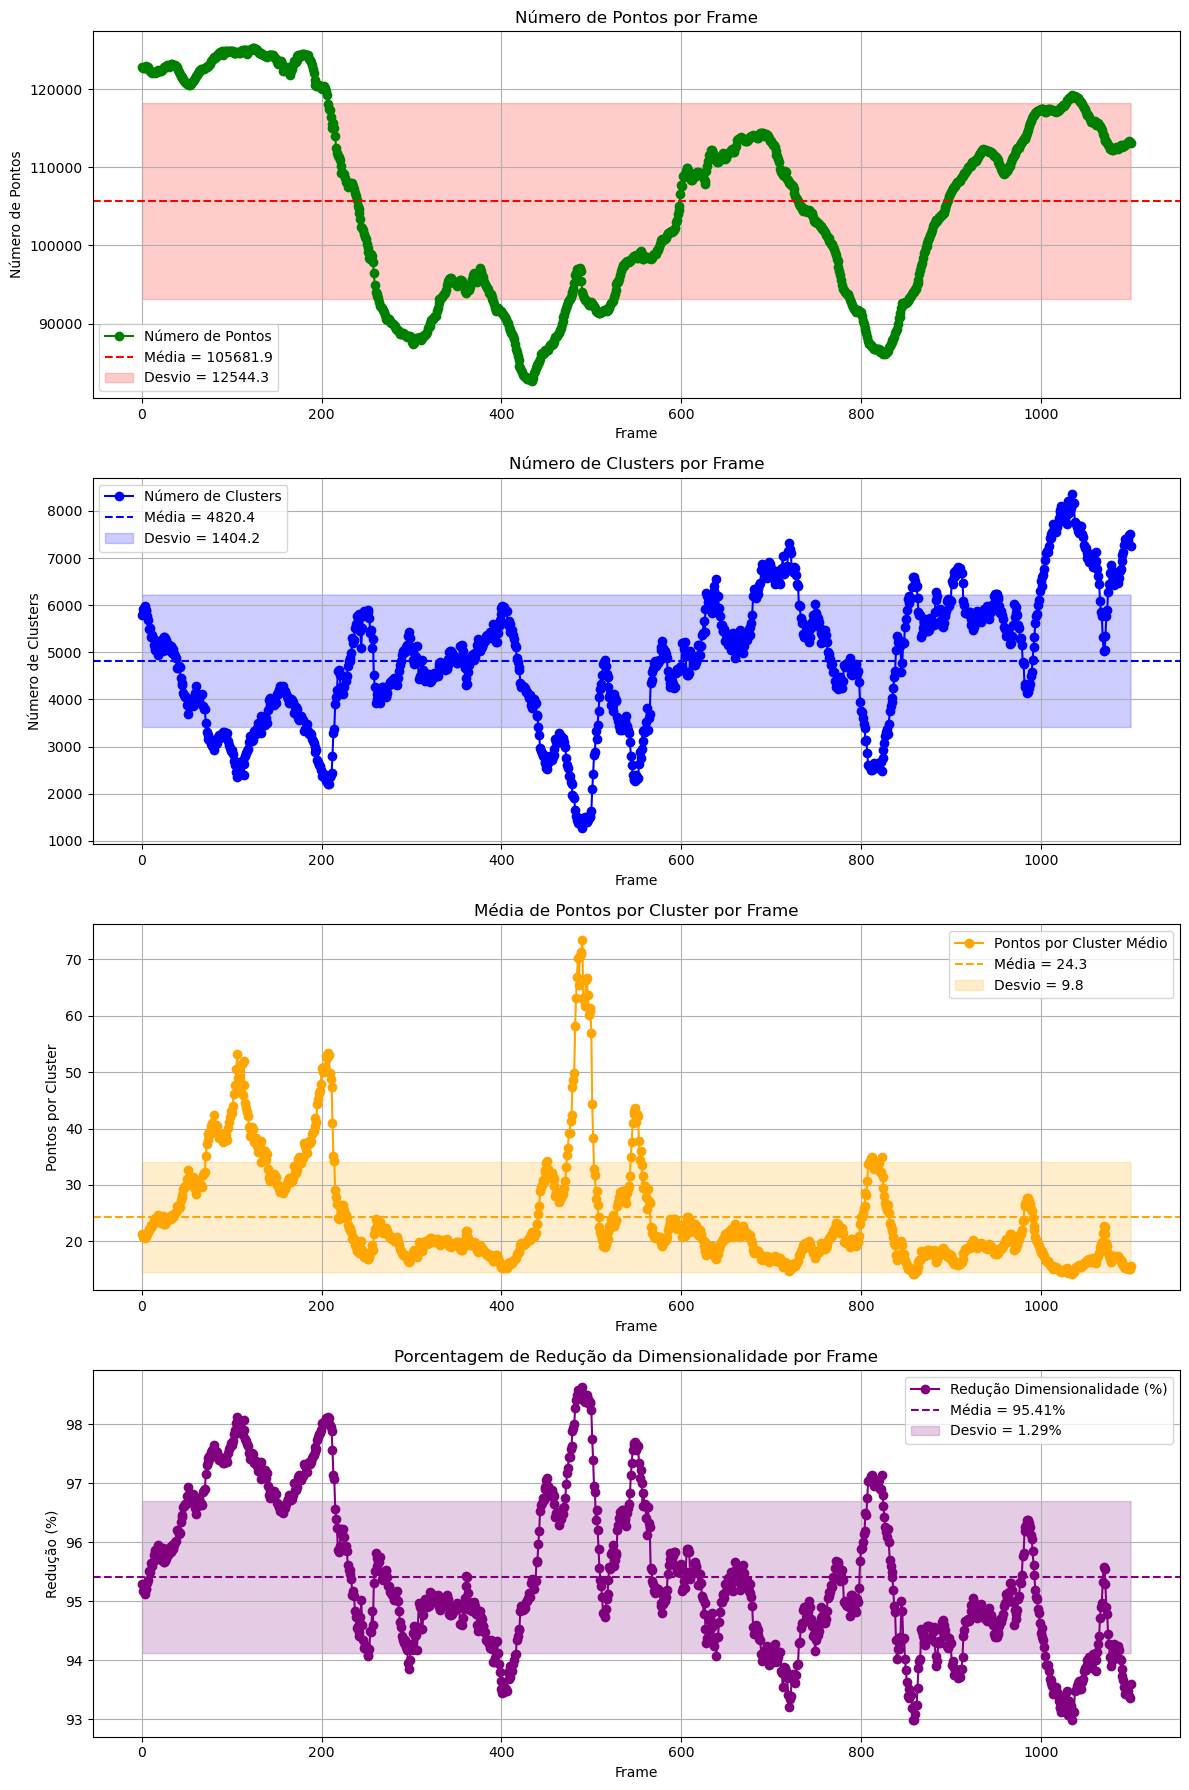

In [27]:
import matplotlib.pyplot as plt
import numpy as np

def plotar_todas_estatisticas(resumo_por_frame, salvar_em=None):
    """
    Plota em 4 subplots verticais:
    1. Número total de pontos
    2. Número total de clusters
    3. Pontos por cluster médio
    4. Porcentagem de redução da dimensionalidade
    """

    # Extrair dados
    num_clusters = np.array([f['num_clusters'] for f in resumo_por_frame])
    num_pontos = np.array([f['num_pontos'] for f in resumo_por_frame])
    pontos_por_cluster_medio = np.array([f['pontos_por_cluster_medio'] for f in resumo_por_frame])
    frames = np.arange(len(resumo_por_frame))

    # Calcular a redução de dimensionalidade
    reducao_dimensionalidade = 1 - (num_clusters / num_pontos)

    # Criar subplots
    fig, axs = plt.subplots(4, 1, figsize=(12, 18))  # 4 linhas, 1 coluna
    fig.tight_layout(pad=5.0)

    # Plot 1 - Número de pontos
    media_pontos = np.mean(num_pontos)
    desvio_pontos = np.std(num_pontos)
    axs[0].plot(frames, num_pontos, marker='o', label='Número de Pontos', color='green')
    axs[0].axhline(media_pontos, color='red', linestyle='--', label=f'Média = {media_pontos:.1f}')
    axs[0].fill_between(frames, media_pontos - desvio_pontos, media_pontos + desvio_pontos,
                        color='red', alpha=0.2, label=f'Desvio = {desvio_pontos:.1f}')
    axs[0].set_title('Número de Pontos por Frame')
    axs[0].set_xlabel('Frame')
    axs[0].set_ylabel('Número de Pontos')
    axs[0].legend()
    axs[0].grid(True)

    # Plot 2 - Número de clusters
    media_clusters = np.mean(num_clusters)
    desvio_clusters = np.std(num_clusters)
    axs[1].plot(frames, num_clusters, marker='o', label='Número de Clusters', color='blue')
    axs[1].axhline(media_clusters, color='blue', linestyle='--', label=f'Média = {media_clusters:.1f}')
    axs[1].fill_between(frames, media_clusters - desvio_clusters, media_clusters + desvio_clusters,
                        color='blue', alpha=0.2, label=f'Desvio = {desvio_clusters:.1f}')
    axs[1].set_title('Número de Clusters por Frame')
    axs[1].set_xlabel('Frame')
    axs[1].set_ylabel('Número de Clusters')
    axs[1].legend()
    axs[1].grid(True)

    # Plot 3 - Pontos por cluster médio
    media_ppc = np.mean(pontos_por_cluster_medio)
    desvio_ppc = np.std(pontos_por_cluster_medio)
    axs[2].plot(frames, pontos_por_cluster_medio, marker='o', label='Pontos por Cluster Médio', color='orange')
    axs[2].axhline(media_ppc, color='orange', linestyle='--', label=f'Média = {media_ppc:.1f}')
    axs[2].fill_between(frames, media_ppc - desvio_ppc, media_ppc + desvio_ppc,
                        color='orange', alpha=0.2, label=f'Desvio = {desvio_ppc:.1f}')
    axs[2].set_title('Média de Pontos por Cluster por Frame')
    axs[2].set_xlabel('Frame')
    axs[2].set_ylabel('Pontos por Cluster')
    axs[2].legend()
    axs[2].grid(True)

    # Plot 4 - Redução da dimensionalidade
    media_reducao = np.mean(reducao_dimensionalidade)
    desvio_reducao = np.std(reducao_dimensionalidade)
    axs[3].plot(frames, reducao_dimensionalidade * 100, marker='o', label='Redução Dimensionalidade (%)', color='purple')
    axs[3].axhline(media_reducao * 100, color='purple', linestyle='--', label=f'Média = {media_reducao*100:.2f}%')
    axs[3].fill_between(frames,
                        (media_reducao - desvio_reducao) * 100,
                        (media_reducao + desvio_reducao) * 100,
                        color='purple', alpha=0.2, label=f'Desvio = {desvio_reducao*100:.2f}%')
    axs[3].set_title('Porcentagem de Redução da Dimensionalidade por Frame')
    axs[3].set_xlabel('Frame')
    axs[3].set_ylabel('Redução (%)')
    axs[3].legend()
    axs[3].grid(True)

    # Ajuste layout final
    plt.tight_layout()
    plt.show()
    fig.savefig(f'plots/{SEQ_VALUE}/plot-1.png', dpi=300, bbox_inches='tight')

# Exemplo de chamada
plotar_todas_estatisticas(resumo_por_frame)


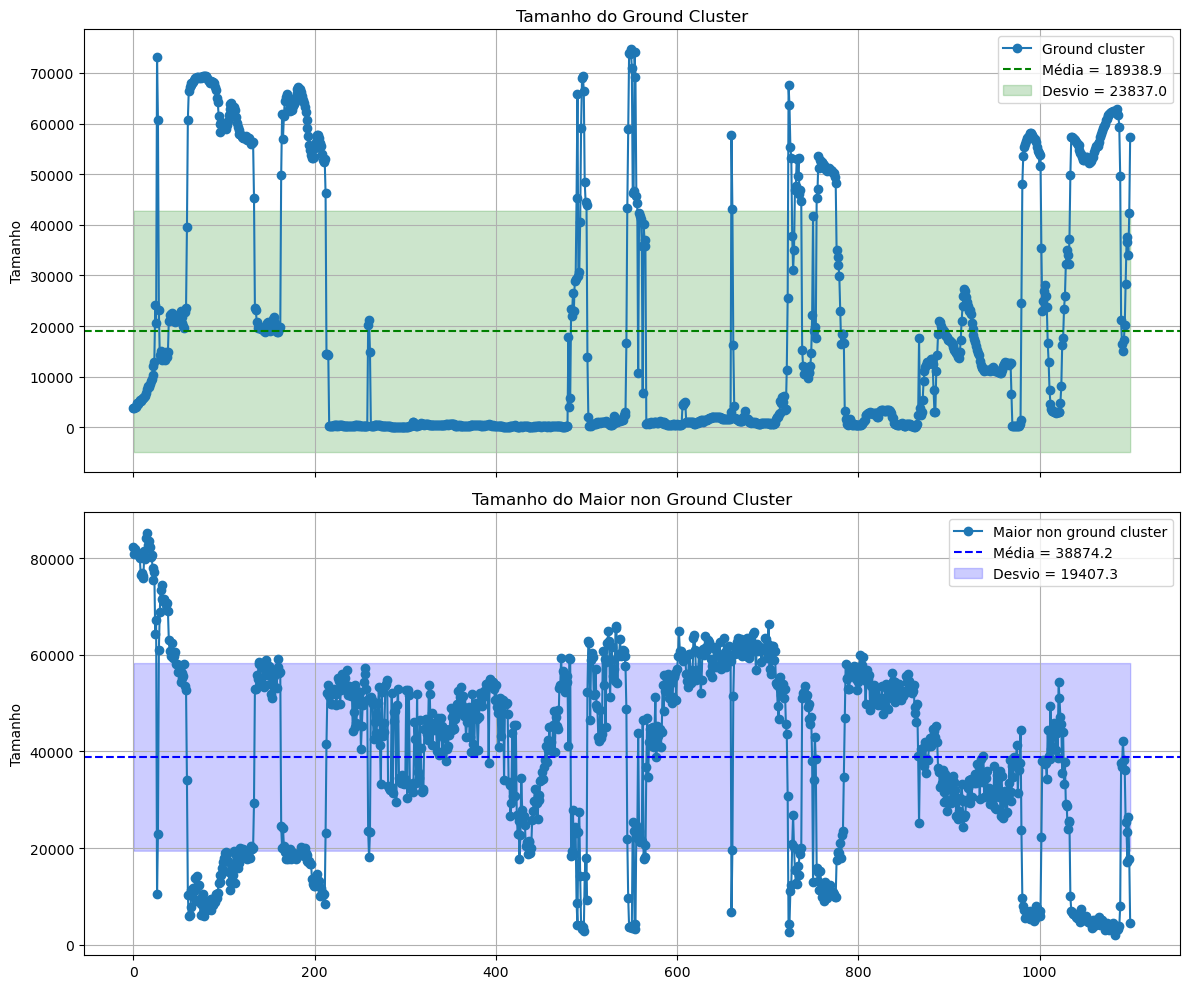

In [28]:
import matplotlib.pyplot as plt
import numpy as np

# Extração dos valores por frame
gound_cluster_size = [f['gound_cluster_size'] for f in resumo_por_frame]
largest_non_ground_cluster = [f['largest_non_ground_cluster'] for f in resumo_por_frame]

# Cálculo de estatísticas
def get_stats(values):
    return np.mean(values), np.std(values)

mean_9, std_9 = get_stats(gound_cluster_size)
mean_second, std_second = get_stats(largest_non_ground_cluster)

# Plot
fig, axs = plt.subplots(2, 1, figsize=(12, 10), sharex=True)

# Cluster 9
axs[0].plot(gound_cluster_size, marker='o', label='Ground cluster')
axs[0].axhline(mean_9, color='green', linestyle='--', label=f'Média = {mean_9:.1f}')
axs[0].fill_between(range(len(gound_cluster_size)), mean_9 - std_9, mean_9 + std_9, color='green', alpha=0.2, label=f'Desvio = {std_9:.1f}')
axs[0].set_ylabel('Tamanho')
axs[0].set_title('Tamanho do Ground Cluster')
axs[0].legend()
axs[0].grid(True)

# Segundo maior
axs[1].plot(largest_non_ground_cluster, marker='o', label='Maior non ground cluster')
axs[1].axhline(mean_second, color='blue', linestyle='--', label=f'Média = {mean_second:.1f}')
axs[1].fill_between(range(len(largest_non_ground_cluster)), mean_second - std_second, mean_second + std_second, color='blue', alpha=0.2, label=f'Desvio = {std_second:.1f}')
axs[1].set_ylabel('Tamanho')
axs[1].set_title('Tamanho do Maior non Ground Cluster')
axs[1].legend()
axs[1].grid(True)

plt.tight_layout()
plt.show()
fig.savefig(f'plots/{SEQ_VALUE}/plot-2.png', dpi=300, bbox_inches='tight')



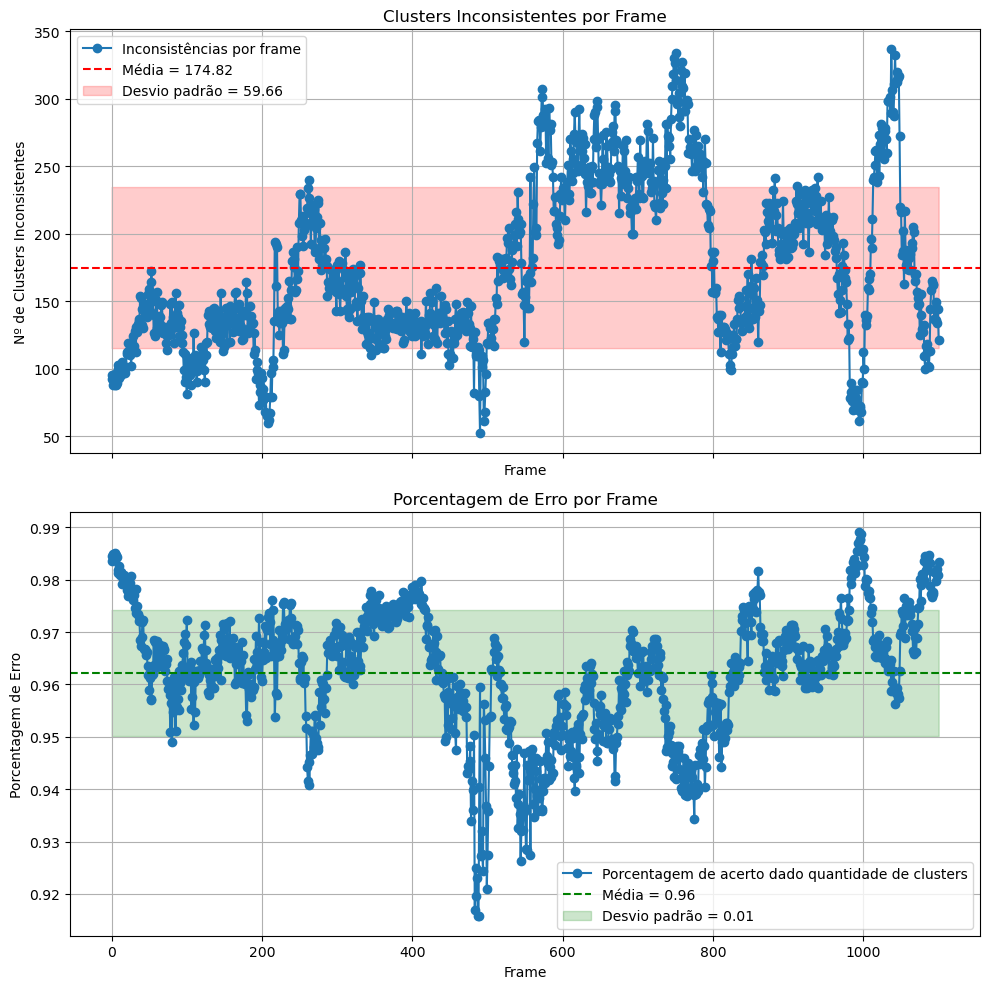

In [38]:
import numpy as np
import matplotlib.pyplot as plt

def plotar_inconsistencias(resumo_por_frame):
    """
    Plota a quantidade de clusters inconsistentes por frame,
    incluindo média e desvio padrão, juntamente com a porcentagem de erro.
    """
    inconsistentes_por_frame = np.array([
        frame['num_clusters_inconsistentes'] for frame in resumo_por_frame
    ])
    num_clusters_por_frame = np.array([
        frame['num_clusters'] for frame in resumo_por_frame
    ])
    
    # Calcular a porcentagem de erro
    porcentagem_erro = 1 - (inconsistentes_por_frame / num_clusters_por_frame)
    porcentagem_erro = np.clip(porcentagem_erro, 0, 1)
    
    # Média e desvio padrão de inconsistências
    media_inconsistencias = np.mean(inconsistentes_por_frame)
    desvio_inconsistencias = np.std(inconsistentes_por_frame)

    # Média e desvio padrão de porcentagem de erro
    media_erro = np.mean(porcentagem_erro)
    desvio_erro = np.std(porcentagem_erro)

    # --- Aqui a mudança ---
    fig, axs = plt.subplots(2, 1, figsize=(10, 10), sharex=True)

    # Gráfico de inconsistências
    axs[0].plot(inconsistentes_por_frame, marker='o', label='Inconsistências por frame')
    axs[0].axhline(media_inconsistencias, color='red', linestyle='--', label=f'Média = {media_inconsistencias:.2f}')
    axs[0].fill_between(
        range(len(inconsistentes_por_frame)),
        media_inconsistencias - desvio_inconsistencias,
        media_inconsistencias + desvio_inconsistencias,
        color='red',
        alpha=0.2,
        label=f'Desvio padrão = {desvio_inconsistencias:.2f}'
    )
    axs[0].set_title('Clusters Inconsistentes por Frame')
    axs[0].set_xlabel('Frame')
    axs[0].set_ylabel('Nº de Clusters Inconsistentes')
    axs[0].grid(True)
    axs[0].legend()

    # Gráfico de porcentagem de erro
    axs[1].plot(porcentagem_erro, marker='o', label='Porcentagem de acerto dado quantidade de clusters')
    axs[1].axhline(media_erro, color='green', linestyle='--', label=f'Média = {media_erro:.2f}')
    axs[1].fill_between(
        range(len(porcentagem_erro)),
        media_erro - desvio_erro,
        media_erro + desvio_erro,
        color='green',
        alpha=0.2,
        label=f'Desvio padrão = {desvio_erro:.2f}'
    )
    axs[1].set_title('Porcentagem de Erro por Frame')
    axs[1].set_xlabel('Frame')
    axs[1].set_ylabel('Porcentagem de Erro')
    axs[1].grid(True)
    axs[1].legend()

    plt.tight_layout()

    # Salvar antes de mostrar
    fig.savefig(f'plots/{SEQ_VALUE}/plot-3.png', dpi=300, bbox_inches='tight')
    plt.show()

    return inconsistentes_por_frame, media_inconsistencias, desvio_inconsistencias, porcentagem_erro, media_erro, desvio_erro


v = plotar_inconsistencias(resumo_por_frame)

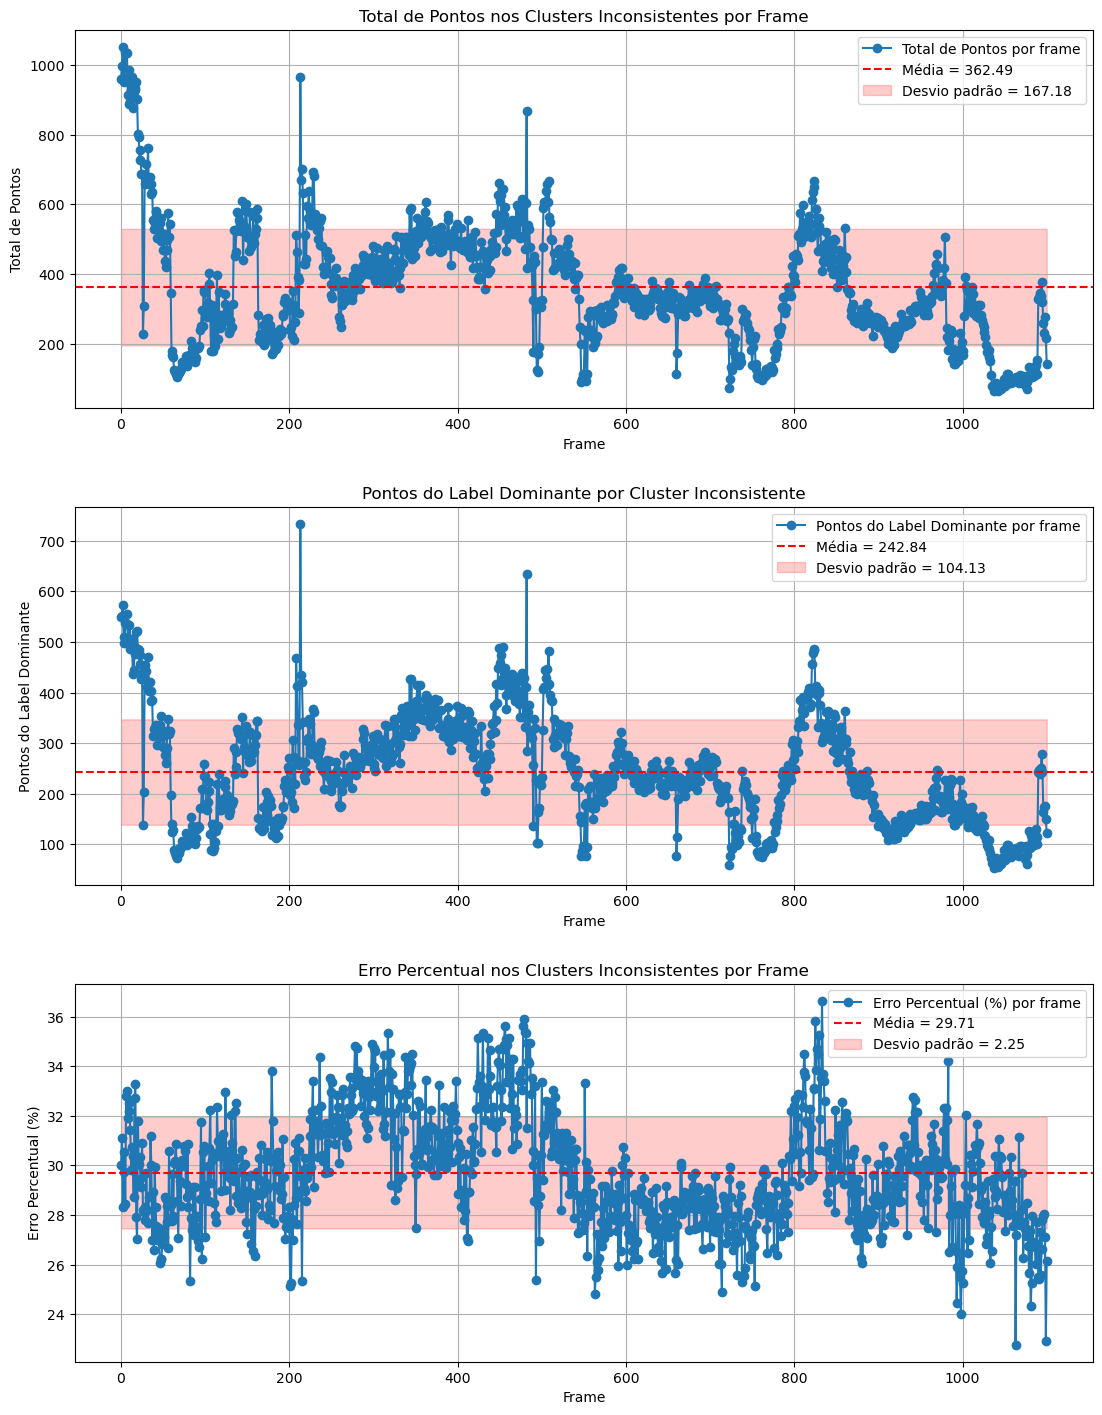

In [30]:
import matplotlib.pyplot as plt
import numpy as np

def plotar_estatisticas_erro_multiplos(resumo_por_frame):
    """
    Plota três métricas de erro em subplots separados, mas no mesmo figure.
    """

    # Configurações para as 3 métricas
    metricas = [
        {
            'chave_media': 'media_total_pontos',
            'chave_std': 'std_total_pontos',
            'titulo': 'Total de Pontos nos Clusters Inconsistentes por Frame',
            'ylabel': 'Total de Pontos'
        },
        {
            'chave_media': 'media_pontos_label_dominante',
            'chave_std': 'std_pontos_label_dominante',
            'titulo': 'Pontos do Label Dominante por Cluster Inconsistente',
            'ylabel': 'Pontos do Label Dominante'
        },
        {
            'chave_media': 'media_erro_percentual',
            'chave_std': 'std_erro_percentual',
            'titulo': 'Erro Percentual nos Clusters Inconsistentes por Frame',
            'ylabel': 'Erro Percentual (%)'
        }
    ]

    # Criar subplots
    fig, axs = plt.subplots(3, 1, figsize=(12, 15))  # 3 linhas, 1 coluna
    fig.tight_layout(pad=5.0)

    for idx, config in enumerate(metricas):
        chave_media = config['chave_media']
        chave_std = config['chave_std']
        titulo = config['titulo']
        ylabel = config['ylabel']

        metricas_por_frame = np.array([
            frame['erros_clusters'][chave_media] for frame in resumo_por_frame
        ])
        media_global = np.mean(metricas_por_frame)
        desvio_global = np.std(metricas_por_frame)

        ax = axs[idx]
        ax.plot(metricas_por_frame, marker='o', label=f'{ylabel} por frame')
        ax.axhline(media_global, color='red', linestyle='--', label=f'Média = {media_global:.2f}')
        ax.fill_between(
            range(len(metricas_por_frame)),
            media_global - desvio_global,
            media_global + desvio_global,
            color='red',
            alpha=0.2,
            label=f'Desvio padrão = {desvio_global:.2f}'
        )
        ax.set_title(titulo)
        ax.set_xlabel('Frame')
        ax.set_ylabel(ylabel)
        ax.legend()
        ax.grid(True)

    plt.show()
    fig.savefig(f'plots/{SEQ_VALUE}/plot-4.png', dpi=300, bbox_inches='tight')


v = plotar_estatisticas_erro_multiplos(resumo_por_frame)

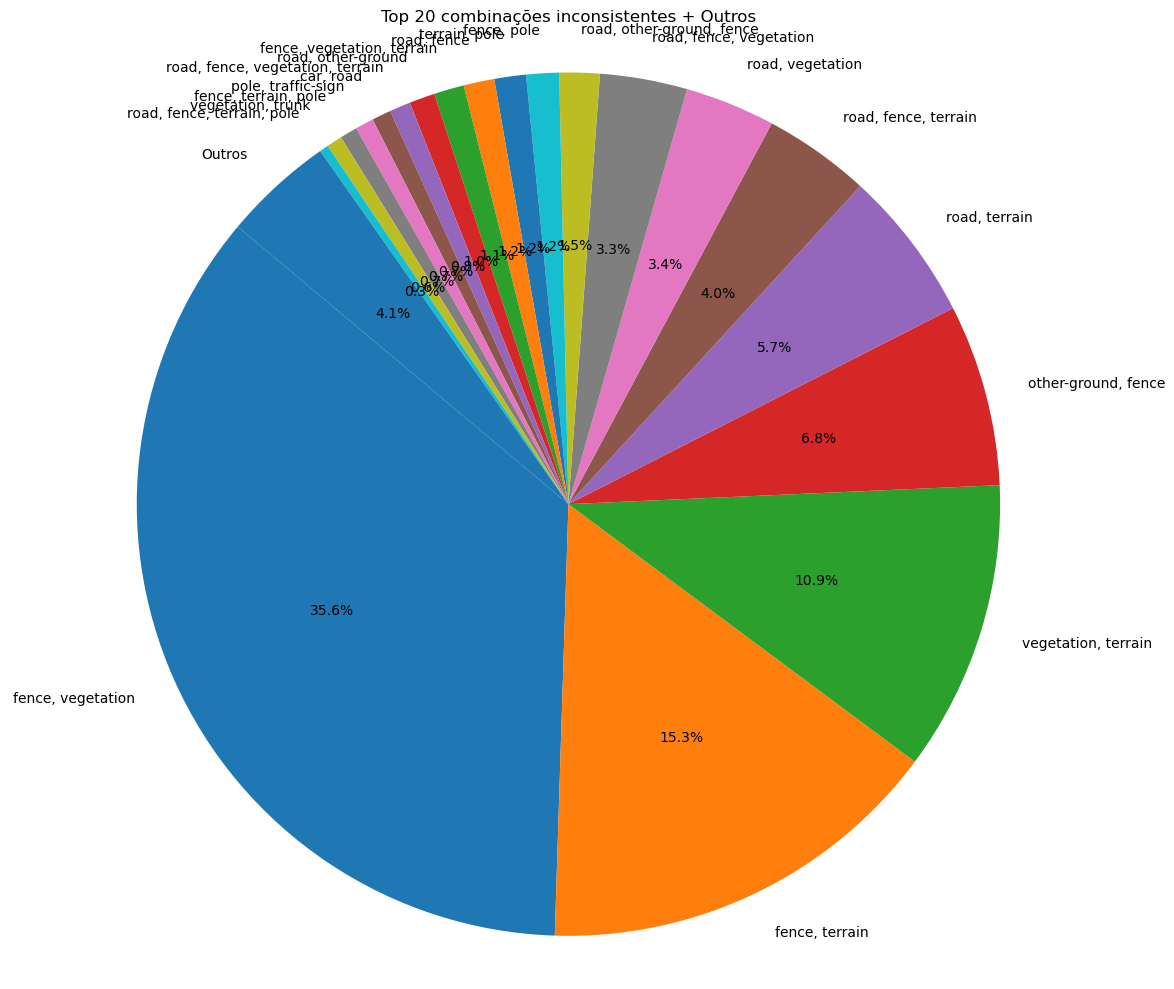

In [39]:
import matplotlib.pyplot as plt

# Extrair as combinações e suas contagens

# Pegar top 20
top_30_combinacoes = combinacoes_ordenadas[:20]

# Separar nomes e valores
def formatar_combinacao(combinacao):
    nomes = [label_id_to_name.get(int(l), f"desconhecido({l})") for l in combinacao]
    return ", ".join(nomes)

labels_pizza = [formatar_combinacao(comb) for comb, _ in top_30_combinacoes]
valores_pizza = [contagem for _, contagem in top_30_combinacoes]

# Calcular "outros"
total = sum(combinacoes_geral.values())
total_top_30 = sum(valores_pizza)
outros = total - total_top_30

if outros > 0:
    labels_pizza.append('Outros')
    valores_pizza.append(outros)

# --- Correção: guardar a figura ---
fig, ax = plt.subplots(figsize=(12, 10))

ax.pie(valores_pizza, labels=labels_pizza, autopct='%1.1f%%', startangle=140)
ax.set_title("Top 20 combinações inconsistentes + Outros")
ax.axis('equal')  # Deixa a pizza redonda

plt.tight_layout()

# Salvar antes de mostrar
fig.savefig(f'plots/{SEQ_VALUE}/plot-5.png', dpi=300, bbox_inches='tight')
plt.show()
